## Simplistic down-scaling / lower res filling of base resolution sampled test data

In [16]:
import pandas as pd
import numpy as np
from h3 import h3

df = pd.read_csv("h3_agg.csv")

df = df.rename(columns={'code_18': "corine_landuse", "percipitation":"precipitation", "Varv": "soil_class"})

display(df.describe())

df.sample(3)

,elevation,corine_landuse,temperature,precipitation,population,soil_class
count,124767.000000,124767.000000,124767.000000,124767.000000,124767.000000,88776.000000
mean,39.184832,306.372871,-32.096019,487.100083,8.764933,6.606932
std,37.905403,149.353962,20.975767,278.413802,143.997517,6.853250
min,-0.686404,0.000000,-61.000000,0.000000,0.000000,0.000000
25%,0.256986,211.000000,-50.000000,564.000000,0.000000,1.000000
50%,33.173809,311.000000,-42.000000,621.000000,0.149468,4.000000
75%,62.688461,512.000000,-10.000000,661.000000,1.125973,11.000000
max,278.191096,523.000000,0.000000,783.000000,31795.673828,22.000000


,cell_id,elevation,corine_landuse,temperature,precipitation,population,soil_class
83217,881135d0cdfffff,90.992812,312,-49.0,635.0,0.216705,11.0
49050,8811308945fffff,27.985562,512,-50.0,579.0,0.000000,0.0
93744,8811369067fffff,59.707025,211,-47.0,636.0,0.447482,1.0


In [17]:
import rhealpixdggs as rhpix
import rhealpixdggs.dggs as rhpix_dggs

def get_rhpix_geoid():
    rhpix_geoid = rhpix_dggs.WGS84_003
    return rhpix_geoid

default_rhpix_geoid = get_rhpix_geoid()


def rhpix_to_parent_fast(cell_suid):
    return cell_suid[:-1]


def h3_all_parents(base_cell, lowest_res=1):
    res = h3.h3_get_resolution(base_cell)
    t_cell = base_cell
    parents = []
    while res > lowest_res:
        parent = h3.h3_to_parent(t_cell)
        parents.append(parent)
        t_cell = parent
        res = h3.h3_get_resolution(parent)
    return parents

    
def rhpix_all_parents(base_cell, lowest_res=1, fast=True, rhpix_geoid=None):
    # RHPIX res 0 is the main Q etc shapes
    res = len(base_cell)-1
    t_cell = base_cell
    parents = []
    while res > lowest_res:
        parent = rhpix_to_parent_fast(t_cell) if fast else rhpix_to_parent(t_cell, rhpix_geoid)
        parents.append(parent)
        t_cell = parent
        res = len(parent)
    return parents

In [21]:
def dggs_to_parent(cell_id, dggs_type="H3"):
    if dggs_type == "H3":
        return h3.h3_to_parent(cell_id)
    elif dggs_type == "RHEALPIX":
        return rhpix_to_parent_fast(cell_id)
    else:
        raise NotImplementedError("DGGS type not implemented")


def dggs_all_parents(base_cell, lowest_res=1, dggs_type="H3"):
    if dggs_type == "H3":
        return h3_all_parents(base_cell, lowest_res)
    elif dggs_type == "RHEALPIX":
        return rhpix_all_parents(base_cell, lowest_res=1, fast=True, rhpix_geoid=default_rhpix_geoid)
    else:
        raise NotImplementedError("DGGS type not implemented")


def get_mode_count(df, col_name):
    modes = df[col_name].value_counts()
    return len(modes)


def get_def_stat(df, col_name, stat_name):
    if stat_name == "mean":
        return df[col_name].mean()
    elif stat_name == "median":
        return df[col_name].median()
    elif stat_name == 'count':
        return df[col_name].count()
    elif stat_name == 'std':
        return df[col_name].std()
    elif stat_name == "mode":
        series = df.apply(lambda sub: sub[col_name].mode()[0])
        series.name = col_name
        return series
    elif stat_name == "mode_count":
        series = df.apply(lambda sub: get_mode_count(sub, col_name))
        series.name = col_name
        return series
    else:
        print("shouldnt be here")
        return np.nan
    
# you have to decide for scalar (mean/median plus std/count) or categorical (mode plus mode_count/count) yourself
def prep_single_var_dggs(data, base_resolution, min_resolution, var_name, main_stat='mean', uncert_stats=['count', 'std'], dggs_type="H3"):

    parent_df = []

    variable = var_name
    df = data.copy()
    first_parent_res = base_resolution - 1
    non_incl_min_res = min_resolution - 1
    
    df['parent_ids'] = df['cell_id'].apply(lambda x: ":".join(dggs_all_parents(x, lowest_res=2, dggs_type=dggs_type)))

    for idx in range(first_parent_res,non_incl_min_res,-1):
        print(idx)
        
        if f'parent_id_{idx+1}' not in df.columns and idx+1 == base_resolution:
            df[f'parent_id_{idx+1}'] = df['cell_id']

        df[f'parent_id_{idx}'] = df[f'parent_id_{idx+1}'].map(lambda x: dggs_to_parent(x, dggs_type=dggs_type))

        # [variable].describe()
        df_grouped = df.groupby(f'parent_id_{idx}')
        
        t8 = None

        if main_stat == "mean":
            t8 = get_def_stat(df_grouped, var_name, main_stat)
        elif main_stat == "median":
            t8 = get_def_stat(df_grouped, var_name, main_stat)
        elif main_stat == "mode":
            t8 = get_def_stat(df_grouped, var_name, main_stat)
        
        t8 = pd.DataFrame(t8)
        uncert_cols = []

        if main_stat in ["mean", "median"]:
            for stat_name in filter(lambda s: s in ['count', 'std'], uncert_stats):
                uncert_cols.append(f"{var_name}_{stat_name}")
                if stat_name == 'count':
                    t8[f"{var_name}_{stat_name}"] = get_def_stat(df_grouped, var_name, stat_name)
                    t8[f"{var_name}_{stat_name}"] = pd.to_numeric(t8[f"{var_name}_{stat_name}"], downcast='integer')
                elif stat_name == 'std':
                    t8[f"{var_name}_{stat_name}"] = get_def_stat(df_grouped, var_name, stat_name)

        elif main_stat == "mode":
            for stat_name in filter(lambda s: s in ['count', 'mode_count'], uncert_stats):
                uncert_cols.append(f"{var_name}_{stat_name}")
                if stat_name == 'count':
                    t8[f"{var_name}_{stat_name}"] = get_def_stat(df_grouped, var_name, stat_name)
                    t8[f"{var_name}_{stat_name}"] = pd.to_numeric(t8[f"{var_name}_{stat_name}"], downcast='integer')
                elif stat_name == 'mode_count':
                    t8[f"{var_name}_{stat_name}"] = get_def_stat(df_grouped, var_name, stat_name)
                    t8[f"{var_name}_{stat_name}"] = pd.to_numeric(t8[f"{var_name}_{stat_name}"], downcast='integer')


        t8 = t8.reset_index(drop=False)
        t8['cell_id'] = t8[f'parent_id_{idx}']
        t8['resolution'] = idx
        t8['parent_ids'] = t8['cell_id'].apply(lambda x: ":".join(dggs_all_parents(x, lowest_res=non_incl_min_res, dggs_type=dggs_type)))

        t8 = t8[['cell_id', var_name, 'resolution', 'parent_ids'] + uncert_cols]

        parent_df.append(t8)

    subs = pd.concat(parent_df)

    elev = df[['cell_id',var_name, 'parent_ids']].copy()
    elev['resolution']  = base_resolution
    for col in uncert_stats:
        if col in ['count', 'mode_count']:
            elev[f"{var_name}_{col}"]  = 1
        elif col in ['std']:
            elev[f"{var_name}_{col}"]  = 0
    elev = pd.concat([elev, subs])

    return elev


In [20]:
variable = "precipitation"

precip = prep_single_var_dggs(data=df, base_resolution=8,
                              min_resolution=2, var_name=variable,
                              main_stat='mean', uncert_stats=['count', 'std'],
                              dggs_type="H3")

display(precip.info())
display(precip.describe())

precip.sample(5)

7
6
5
4
3
2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 145935 entries, 0 to 4
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   cell_id              145935 non-null  object 
 1   precipitation        145935 non-null  float64
 2   parent_ids           145935 non-null  object 
 3   resolution           145935 non-null  int64  
 4   precipitation_count  145935 non-null  int64  
 5   precipitation_std    145873 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 7.8+ MB


None

,precipitation,resolution,precipitation_count,precipitation_std
count,145935.000000,145935.000000,145935.000000,145873.000000
mean,486.539854,7.829218,5.984644,3.182349
std,277.696856,0.450996,226.907363,25.336844
min,0.000000,2.000000,1.000000,0.000000
25%,550.000000,8.000000,1.000000,0.000000
50%,620.000000,8.000000,1.000000,0.000000
75%,661.000000,8.000000,1.000000,0.000000
max,783.000000,8.000000,56885.000000,401.636652


,cell_id,precipitation,parent_ids,resolution,precipitation_count,precipitation_std
103718,881f6480c9fffff,0.000000,871f6480cffffff:861f6480fffffff:851f6483ffffff...,8,1,0.000000
8386,871134021ffffff,672.142857,861134027ffffff:85113403fffffff:8411341fffffff...,7,7,5.273474
11497,88089a519dfffff,621.000000,87089a519ffffff:86089a51fffffff:85089a53ffffff...,8,1,0.000000
5967,88089a092dfffff,644.000000,87089a092ffffff:86089a097ffffff:85089a0bffffff...,8,1,0.000000
47434,8811305609fffff,611.000000,871130560ffffff:861130567ffffff:85113057ffffff...,8,1,0.000000


In [23]:
variable = "elevation"

elev = prep_single_var_dggs(data=df, base_resolution=8,
                              min_resolution=2, var_name=variable,
                              main_stat='mean', uncert_stats=['count', 'std'],
                              dggs_type="H3")

display(elev.info())
display(elev.describe())

elev.sample(5)

7
6
5
4
3
2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 145935 entries, 0 to 4
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cell_id          145935 non-null  object 
 1   elevation        145935 non-null  float64
 2   parent_ids       145935 non-null  object 
 3   resolution       145935 non-null  int64  
 4   elevation_count  145935 non-null  int64  
 5   elevation_std    145873 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 7.8+ MB


None

,elevation,resolution,elevation_count,elevation_std
count,145935.000000,145935.000000,145935.000000,145873.000000
mean,39.141772,7.829218,5.984644,0.365196
std,37.886907,0.450996,226.907363,1.625518
min,-0.686404,2.000000,1.000000,0.000000
25%,0.396949,8.000000,1.000000,0.000000
50%,33.134811,8.000000,1.000000,0.000000
75%,62.632599,8.000000,1.000000,0.000000
max,278.191096,8.000000,56885.000000,97.862109


,cell_id,elevation,parent_ids,resolution,elevation_count,elevation_std
57434,88113296ebfffff,33.960888,87113296effffff:86113296fffffff:85113297ffffff...,8,1,0.0
13505,88089a6d1bfffff,26.571586,87089a6d1ffffff:86089a6d7ffffff:85089a6fffffff...,8,1,0.0
50002,8811309485fffff,56.711803,871130948ffffff:86113094fffffff:85113097ffffff...,8,1,0.0
49446,8811308dcdfffff,28.001603,8711308dcffffff:8611308dfffffff:8511308fffffff...,8,1,0.0
105654,881f649713fffff,1.595607,871f64971ffffff:861f64977ffffff:851f6497ffffff...,8,1,0.0


In [1]:
import sqlite3

conn = sqlite3.connect('test.db')
c = conn.cursor()

In [2]:
rs = c.execute("select * from dggs_catalog;")

In [3]:
for row in rs:
    print(row)

('srtm_30m_estonia_h3', 'H3', '24,58,27,59', 8, '8:7:6:5:4:3:2', 'elevation', '30m SRTM sampled at res 8 covering Estonia', 'https://landscape-geoinformatics.ut.ee/dggs-en', 1634280469, None)
('srtm_30m_estonia_rhpix', 'RHEALPIX', '24,58,27,59', 8, '8:7:6:5:4:3:2', 'elevation', '30m SRTM re-sampled at res 8 from the H3 dataset covering Estonia', 'https://landscape-geoinformatics.ut.ee/dggs-en', 1634991567, None)
('corine_lulc_estonia_h3', 'H3', '24,58,27,59', 8, '8:7:6:5:4:3:2', 'corine_landuse', 'CORINE Landuse/land cover classes sampled at res 8 covering Estonia', 'https://landscape-geoinformatics.ut.ee/dggs-en', 1634991567, None)
('corine_lulc_estonia_rhpix', 'RHEALPIX', '24,58,27,59', 8, '8:7:6:5:4:3:2', 'corine_landuse', 'CORINE Landuse/land cover classes re-sampled from H3 dataset at res 8 covering Estonia', 'https://landscape-geoinformatics.ut.ee/dggs-en', 1634991567, None)


In [98]:
rs = c.execute("select * from srtm_30m_estonia_h3 where resolution=8 limit 1;")

In [99]:
for row in rs:
    print(row)

('8808932091fffff', 0.0, 8, '870893209ffffff:86089320fffffff:85089323fffffff:8408933ffffffff:830893fffffffff:820897fffffffff', 1, 0.0)


In [23]:
elev.to_sql('srtm_30m_estonia_h3', conn, if_exists='append', index = False)

In [81]:
c.close()

In [82]:
conn.close()

## some additional sqlite3 tests

In [7]:
import sqlite3

conn = sqlite3.connect('test.db')
c = conn.cursor()

In [34]:
rs = conn.execute(
        "SELECT table_name, dggs_type, resolutions, variables, description, meta_url, extent, date_loaded FROM dggs_catalog"
        # "SELECT table_name, dggs_type, resolutions, variables, description, meta_url FROM dggs_catalog"
    )
    

In [35]:
c_list = []

field_names = [description[0] for description in rs.description]

for row in rs:
    links = [row[5]] if row[5] is not None else []
    resolutions = row[2].split(":") if row[2] is not None else []
    variables = row[3].split(":") if row[3] is not None else []
    extent = [float(x) for x in row[6].split(",") if row[6] is not None]
    
    tx = zip(field_names, row)
    c = dict(tx)
    c_list.append(c)

In [36]:
dict(tx)

{}

In [37]:
c_list

[{'table_name': 'srtm_30m_estonia_h3',
  'dggs_type': 'H3',
  'resolutions': '8:7:6:5:4:3:2',
  'variables': 'elevation',
  'description': '30m SRTM sampled at res 8 covering Estonia',
  'meta_url': 'https://landscape-geoinformatics.ut.ee/dggs-en',
  'extent': '24,58,27,59',
  'date_loaded': 1634280469},
 {'table_name': 'srtm_30m_estonia_rhpix',
  'dggs_type': 'RHEALPIX',
  'resolutions': '8:7:6:5:4:3:2',
  'variables': 'elevation',
  'description': '30m SRTM re-sampled at res 8 from the H3 dataset covering Estonia',
  'meta_url': 'https://landscape-geoinformatics.ut.ee/dggs-en',
  'extent': '24,58,27,59',
  'date_loaded': 1634991567},
 {'table_name': 'corine_lulc_estonia_h3',
  'dggs_type': 'H3',
  'resolutions': '8:7:6:5:4:3:2',
  'variables': 'corine_landuse',
  'description': 'CORINE Landuse/land cover classes sampled at res 8 covering Estonia',
  'meta_url': 'https://landscape-geoinformatics.ut.ee/dggs-en',
  'extent': '24,58,27,59',
  'date_loaded': 1634991567},
 {'table_name': '

In [11]:
collection_id = c_list[0]['id']

rs = conn.execute(
        "SELECT * FROM {} limit 1".format(
            collection_id
        )
    )
names = [description[0] for description in rs.description]

In [12]:
that_row = rs.fetchone()

In [13]:
names

['cell_id',
 'elevation',
 'resolution',
 'parent_ids',
 'elevation_count',
 'elevation_std']

## categorical variable fill down-sampling approach

In [ ]:
variable = "corine_landuse"

# smaller_df = df.head(5000).copy()

lulc_code_h3 = prep_single_var_dggs(data=df, base_resolution=8, min_resolution=2, var_name=variable, main_stat='mode', uncert_stats=['count', 'mode_count'], dggs_type="H3")

display(lulc_code_h3.info())
display(lulc_code_h3.describe())

lulc_code_h3.sample(5)

In [25]:
display(lulc_code_h3.describe())

,corine_landuse,resolution,corine_landuse_count,corine_landuse_mode_count
count,145935.000000,145935.000000,145935.000000,145935.000000
mean,306.166081,7.829218,5.984644,1.224093
std,149.895434,0.450996,226.907363,0.965139
min,0.000000,2.000000,1.000000,1.000000
25%,211.000000,8.000000,1.000000,1.000000
50%,311.000000,8.000000,1.000000,1.000000
75%,512.000000,8.000000,1.000000,1.000000
max,523.000000,8.000000,56885.000000,30.000000


In [26]:
lulc_code_h3.sample(5)

,cell_id,corine_landuse,parent_ids,resolution,corine_landuse_count,corine_landuse_mode_count
74089,881134d66dfffff,231,871134d66ffffff:861134d67ffffff:851134d7ffffff...,8,1,1
14834,88089a80a9fffff,243,87089a80affffff:86089a80fffffff:85089a83ffffff...,8,1,1
47267,881130544bfffff,0,871130544ffffff:861130547ffffff:85113057ffffff...,8,1,1
15657,871f64ba9ffffff,523,861f64bafffffff:851f64bbfffffff:841f64bfffffff...,7,7,1
75104,8811350a21fffff,523,8711350a2ffffff:8611350a7ffffff:8511350bffffff...,8,1,1


<AxesSubplot:>

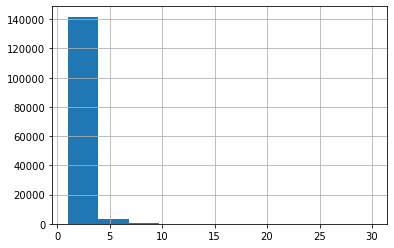

In [28]:
lulc_code_h3['corine_landuse_mode_count'].hist()

In [78]:
lulc_code_h3.loc[lulc_code_h3.resolution == 5].sample(3)

,cell_id,corine_landuse,parent_ids,resolution,corine_landuse_count,corine_landuse_mode_count
203,8511342bfffffff,211,8411343ffffffff:831134fffffffff:821137ffffffff...,5,343,8
239,851134cffffffff,211,841134dffffffff:831134fffffffff:821137ffffffff...,5,343,10
20,850898cbfffffff,523,840898dffffffff:830898fffffffff:82089fffffffff...,5,188,1


In [79]:
# lulc_code_h3.to_sql('corine_lulc_estonia_h3', conn, if_exists='append', index = False)

## Rhealpix

... from the H3 sample test data shortcut here

In [329]:
dfr = df.copy()

In [336]:
dfr.sample(3)

,cell_id,elevation,corine_landuse,temperature,precipitation,population,soil_class,lat,lon
86454,8811361a55fffff,90.084352,242,-51.0,662.0,2.486903,0.0,57.784147,26.611720
82727,881135cacdfffff,96.014835,211,-52.0,583.0,1.926546,2.0,59.315789,26.274715
77624,8811354ea7fffff,45.278443,313,-50.0,613.0,0.059163,0.0,59.338412,27.105288


In [331]:
h3.h3_to_geo('88089aa357fffff')

(58.99513532759096, 23.941331548422617)

In [335]:
dfr['lat'] = dfr.cell_id.apply(lambda x: h3.h3_to_geo(x)[0])
dfr['lon'] = dfr.cell_id.apply(lambda x: h3.h3_to_geo(x)[1])

In [346]:
def rhpix_from_geo( p, resolution, rhpix_geoid=None, plane=False):
    c = rhpix_geoid.cell_from_point(resolution=resolution, p=p, plane=plane)
    cell_id = "".join([str(x) for x in c.suid])
    return cell_id

In [355]:
dfr['cell_id'] = dfr.apply(lambda row: rhpix_from_geo( (row['lon'], row['lat']), 8, default_rhpix_geoid, False), axis=1)

In [31]:
# dfr = pd.read_csv("rhpix_agg.csv")

In [32]:
len(dfr['cell_id'].unique())

36995

In [33]:
dfr.describe()

,elevation,corine_landuse,temperature,precipitation,population,soil_class,lat,lon
count,124767.000000,124767.000000,124767.000000,124767.000000,124767.000000,88776.000000,124767.000000,124767.000000
mean,39.184832,306.372871,-32.096019,487.100083,8.764933,6.606932,58.610163,25.216364
std,37.905403,149.353962,20.975767,278.413802,143.997517,6.853250,0.563005,1.651630
min,-0.686404,0.000000,-61.000000,0.000000,0.000000,0.000000,57.506242,21.763491
25%,0.256986,211.000000,-50.000000,564.000000,0.000000,1.000000,58.142016,23.904675
50%,33.173809,311.000000,-42.000000,621.000000,0.149468,4.000000,58.596048,25.330501
75%,62.688461,512.000000,-10.000000,661.000000,1.125973,11.000000,59.060642,26.598156
max,278.191096,523.000000,0.000000,783.000000,31795.673828,22.000000,59.824321,28.211764


In [87]:
dfr.sample(3)

,cell_id,elevation,corine_landuse,temperature,precipitation,population,soil_class,lat,lon
67901,N15546717,76.111029,211,-45.0,716.0,1.155287,6.0,58.971962,25.247283
6613,N15556041,16.369262,211,-29.0,633.0,1.034179,12.0,58.724180,23.911279
31827,N15571218,51.378658,211,-35.0,652.0,0.822225,2.0,59.108430,24.385640


In [357]:
# dfr.to_csv("rhpix_agg.csv", index=False)

In [38]:
variable = "corine_landuse"

# smaller_df = df.head(5000).copy()

lulc_code_rhpix = prep_single_var_dggs(data=dfr, base_resolution=8, min_resolution=2, var_name=variable, main_stat='mode', uncert_stats=['count', 'mode_count'], dggs_type="RHEALPIX")

display(lulc_code_rhpix.info())
display(lulc_code_rhpix.describe())

lulc_code_rhpix.sample(5)

7
6
5
4
3
2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129587 entries, 0 to 1
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   cell_id                    129587 non-null  object
 1   corine_landuse             129587 non-null  int64 
 2   parent_ids                 129587 non-null  object
 3   resolution                 129587 non-null  int64 
 4   corine_landuse_count       129587 non-null  int64 
 5   corine_landuse_mode_count  129587 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.9+ MB


None

,corine_landuse,resolution,corine_landuse_count,corine_landuse_mode_count
count,129587.000000,129587.000000,129587.000000,129587.000000
mean,306.528494,7.957380,6.739634,1.128547
std,149.644322,0.232146,456.268328,0.901011
min,0.000000,2.000000,1.000000,1.000000
25%,211.000000,8.000000,1.000000,1.000000
50%,311.000000,8.000000,1.000000,1.000000
75%,512.000000,8.000000,1.000000,1.000000
max,523.000000,8.000000,116632.000000,32.000000


,cell_id,corine_landuse,parent_ids,resolution,corine_landuse_count,corine_landuse_mode_count
21231,N15554483,523,N1555448:N155544:N15554:N1555:N155:N15:N1:N,8,1,1
67692,N15546618,324,N1554661:N155466:N15546:N1554:N155:N15:N1:N,8,1,1
59532,N15538454,211,N1553845:N155384:N15538:N1553:N155:N15:N1:N,8,1,1
67128,N15534528,242,N1553452:N155345:N15534:N1553:N155:N15:N1:N,8,1,1
45433,N15481424,131,N1548142:N154814:N15481:N1548:N154:N15:N1:N,8,1,1


In [39]:
lulc_code_rhpix

,cell_id,corine_landuse,parent_ids,resolution,corine_landuse_count,corine_landuse_mode_count
0,N23331748,523,N2333174:N233317:N23331:N2333:N233:N23:N2:N,8,1,1
1,N23331771,523,N2333177:N233317:N23331:N2333:N233:N23:N2:N,8,1,1
2,N23331748,523,N2333174:N233317:N23331:N2333:N233:N23:N2:N,8,1,1
3,N23331747,523,N2333174:N233317:N23331:N2333:N233:N23:N2:N,8,1,1
4,N23331748,523,N2333174:N233317:N23331:N2333:N233:N23:N2:N,8,1,1
...,...,...,...,...,...,...
0,N154,0,N15:N1:N,3,12582,25
1,N155,211,N15:N1:N,3,104050,31
2,N233,523,N23:N2:N,3,8135,22
0,N15,211,N1:N,2,116632,32


<AxesSubplot:>

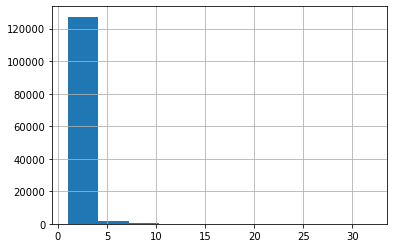

In [74]:
lulc_code_rhpix['corine_landuse_mode_count'].hist()

In [86]:
# lulc_code_rhpix.to_sql('corine_lulc_estonia_rhpix', conn, if_exists='append', index = False)

In [40]:
import folium

In [41]:
def visualize_polygon_features(features, color="red", folium_map=None):
    geom_ext = features[0]['geometry']['coordinates'][0]
    lng = [p[0] for p in geom_ext]
    lat = [p[1] for p in geom_ext]
    if folium_map is None:
        m = folium.Map(height=600, width=800, location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    
    style1 = {'color': '#228B22'}
    style2 = {'color': '#00FFFFFF'}
    
    for f in features:
        # folium.GeoJson(f, name=features[0]['id'],style_function=lambda x: style1 if color == 'red' else style2  ).add_to(m)
        folium.GeoJson(f, name=features[0]['id'],style_function=lambda x: { 'color': color }  ).add_to(m)
    return m

In [49]:
cell = default_rhpix_geoid.cell(['N', 3])
# cell.vertices(plane=False) == cell.boundary(plane=False)
cell.vertices(plane=False)

[(90.0, 74.39069094879062),
 (179.99999999999994, 74.39069094879065),
 (149.99999999999997, 41.87385774220941),
 (119.99999999999999, 41.87385774220941)]

In [66]:
def rhpix_cell_id_to_suid(cell_id):
    resolution = len(cell_id)-1
    suid_text = [x for x in cell_id]
    suid_chain = [ str(suid_text[0]) ]
    for x in suid_text[1:]:
        suid_chain.append(int(x))
    return tuple(suid_chain)


def rhpix_cell_id_to_geom(cell_id, rhpix_geoid=default_rhpix_geoid):
    cell_suid = rhpix_cell_id_to_suid(cell_id)
    c = rhpix_geoid.cell(suid=cell_suid)
    vx = c.vertices(plane=False)
    vx.append(vx[0])
    return vx


def rhpix_to_geojson_feature(rhpix_row_obj, data_vars=[], rhpix_geoid=default_rhpix_geoid):
    cell_id = rhpix_row_obj['cell_id']
    geom = rhpix_cell_id_to_geom(cell_id, rhpix_geoid=default_rhpix_geoid)
    geojson_feature = { 'geometry': {},
         'id': cell_id,
         'links': [],
         'properties': {'resolution': rhpix_row_obj['resolution'] },
         'type': 'Feature' }
    geojson_feature['geometry'] = {'type': 'Polygon',
            'coordinates': [
                geom
            ]
        }
    return geojson_feature

In [67]:
data_vars = list(set(lulc_code_rhpix.columns) - set(["cell_id", "resolution", "parent_ids"]))
data_vars

['corine_landuse_mode_count', 'corine_landuse_count', 'corine_landuse']

In [72]:
rh_json = [  ]

for idx, row in lulc_code_rhpix.loc[lulc_code_rhpix["resolution"] <= 6].sample(100).iterrows():
    zone = rhpix_to_geojson_feature(rhpix_row_obj=row, data_vars=data_vars, rhpix_geoid=default_rhpix_geoid)
    rh_json.append(zone)

In [73]:
visualize_polygon_features(rh_json, color="blue", folium_map=None)

In [88]:
variable = "elevation"

# smaller_df = df.head(5000).copy()

elev_rhpix = prep_single_var_dggs(data=dfr, base_resolution=8, min_resolution=2, var_name=variable, main_stat='mean', uncert_stats=['count', 'std'], dggs_type="RHEALPIX")

display(elev_rhpix.info())
display(elev_rhpix.describe())

elev_rhpix.sample(5)

7
6
5
4
3
2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129587 entries, 0 to 1
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cell_id          129587 non-null  object 
 1   elevation        129587 non-null  float64
 2   parent_ids       129587 non-null  object 
 3   resolution       129587 non-null  int64  
 4   elevation_count  129587 non-null  int64  
 5   elevation_std    129564 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 6.9+ MB


None

,elevation,resolution,elevation_count,elevation_std
count,129587.000000,129587.000000,129587.000000,129564.000000
mean,39.167445,7.957380,6.739634,0.155074
std,37.898220,0.232146,456.268328,1.294757
min,-0.686404,2.000000,1.000000,0.000000
25%,0.346592,8.000000,1.000000,0.000000
50%,33.156785,8.000000,1.000000,0.000000
75%,62.659944,8.000000,1.000000,0.000000
max,278.191096,8.000000,116632.000000,76.714063


,cell_id,elevation,parent_ids,resolution,elevation_count,elevation_std
114257,N15517457,81.271460,N1551745:N155174:N15517:N1551:N155:N15:N1:N,8,1,0.0
85899,N15531511,141.795273,N1553151:N155315:N15531:N1553:N155:N15:N1:N,8,1,0.0
5991,N15545570,18.317381,N1554557:N155455:N15545:N1554:N155:N15:N1:N,8,1,0.0
106471,N15550721,0.000000,N1555072:N155507:N15550:N1555:N155:N15:N1:N,8,1,0.0
4459,N15572582,0.000000,N1557258:N155725:N15572:N1557:N155:N15:N1:N,8,1,0.0


In [89]:
elev_rhpix.loc[elev_rhpix["resolution"] <= 6].sample(20)

,cell_id,elevation,parent_ids,resolution,elevation_count,elevation_std
16,N154574,51.748040,N15457:N1545:N154:N15:N1:N,6,78,9.966430
331,N155553,10.607594,N15555:N1555:N155:N15:N1:N,6,278,3.198161
473,N233302,0.000000,N23330:N2333:N233:N23:N2:N,6,275,0.000000
109,N155265,0.000000,N15526:N1552:N155:N15:N1:N,6,74,0.000000
213,N155412,60.625843,N15541:N1554:N155:N15:N1:N,6,273,8.516526
4,N154528,32.384564,N15452:N1545:N154:N15:N1:N,6,264,2.182224
38,N154816,20.760357,N15481:N1548:N154:N15:N1:N,6,263,14.112949
504,N233364,0.000000,N23336:N2333:N233:N23:N2:N,6,55,0.000000
356,N155581,7.012460,N15558:N1555:N155:N15:N1:N,6,281,4.797605
127,N155306,30.268077,N15530:N1553:N155:N15:N1:N,6,269,1.743308


In [90]:
# elev_rhpix.to_sql('srtm_30m_estonia_rhpix', conn, if_exists='append', index = False)